# 3. Converting back to nucleotides
To be able to look at nucleotide mutations, we need to construct a nucleotide alignment from our original DNA sequences, guided by our protein alignment.

I have not found a good existing tool to do this, but it is actually quite simple. For each sequence obtained from your BLAST search, consider both its AA alignment and its original DNA sequence. Wherever there is a gap in the AA alignment, insert three gaps in the DNA sequence.

HINT: Use your FASTAParser
HINT: zip will let you easily iterate over two iterators (lists, file handles, etc.) in parallel

In [2]:
#Function that will help us read the fasta file
def FASTAReader(file):
    line = file.readline() #read line
    
    assert line.startswith('>'),'Not a fasta file' #asssert is a checkpoint to see if your file is formatted the way you expected it to be formatted
    
    seq_id = line[1:].strip('\n\r') 
    
    sequence = []
    sequences = []
    line = file.readline()
    while line: #will keep processing until the end of the file
        if line.startswith('>'): #same as if there is a new sequence in the file
            sequences.append((seq_id,''.join(sequence))) #will add the new sequence to the set of sequences
            seq_id = line[1:].rstrip('\n\r')
            sequence = [] #will empty the sequence list before continuing
        else: #if its not a new sequence
            sequence.append(line.strip())
        line = file.readline()
        
    sequences.append((seq_id,''.join(sequence))) #these two lines repeat to make sure that the last sequence gets added
    seq_id = line[1:].rstrip('\n\r')
    return sequences

In [3]:
AminoAcids = FASTAReader(open('Alignment_Mafft.txt'))
#open dictionary for amino acids
Amino_dict = {}
#this will add to the dictionary the sequence ID and the amino acid sequence
for seq_id, sequence in AminoAcids:
    Amino_dict[seq_id] = sequence

In [4]:
#same as before but for nucleotides
Nucleotides = FASTAReader(open('seqdump_BLASTN.txt'))
Nucleotide_dict = {}
for seq_id, sequence in Nucleotides:
    Nucleotide_dict[seq_id] = sequence

In [5]:
#make a new list for the combined nucleotides and amino acids
Combined_list = []

In [6]:
#this will make a list of sublists containing the ID, the amino acid seq and the nucleotide seq
Combined_list = zip(Nucleotide_dict.keys(), Amino_dict.values(), Nucleotide_dict.values())

In [7]:
#open lists that will hold the information of the ID and the converted sequence of nucleotides
NucleoSeq = [] 
IDList = []

In [8]:
#create a loop for every sublist
for item in list(Combined_list):
    i=0 #open counter that will help us keep track of the nucleotide position
    IDList.append(item[0]) #apend to a list all the IDs
    AminoCodon = [] #create a list were all the codons will be deposited and clean it after going thorugh a sequence
    for amino in item[1]: #iterate through the amino acids in a sequence
        if "-" in amino: #if there is a gap, add three nucleotide gaps 
            Codon1 = "---"
            AminoCodon.append(Codon1) #make sure to add it to the list of codons
        else:
            Codon2 = item[2][i:i+3] #add to a variable the three nucleotides corresponding to the position of the amino acid
            i += 3 #make sure to change the position of the nucleotide codon
            AminoCodon.append(Codon2) #add it to the list of codons
    NucleoSeq.append(''.join(AminoCodon)) #join the list of codons that we had so that its only one string and add it to the list of nucleotide seq

In [9]:
New_CombinedList = zip(IDList, NucleoSeq) #combine both lists 

# 4. Looking for selection
For each codon in your query sequence, count the number of synonymous (dS) and non-synonymous (dN) changes that occurred in the sequences returned by the BLAST search. (This is why we needed to convert the amino acid alignments back to nucleotides.) If multiple nucleotides have changed in a codon, count this as a single change. This requires you to determine (1) whether the bases in each codon match across sequences, and (2) whether the amino acid encoded by that codon also matches.

We want to test whether the ratio of non-synonymous to synonymous changes is significantly different from what we expect. The simplest way to do this (for a large sample) is to test the null hypothesis dN = dS. D = dN - dS is approximately normal, so a Z test is sufficient. Only include codons that are present in the query sequence and have at least one mutation.

Finally, plot the the codon position by the log2 ratio of dN/dS. (Don’t plot ratios where one of the values is zero.) Use color to indicate which values have a p-value less than 0.05. Don’t worry about multiple testing correction for this.

HINT: The null hypothesis is that there is no selection, i.e. D_0 = 0.
HINT: Estimate the standard deviation from all the values of D you calculate.
HINT: You can get distribution values from scipy.stats
HINT: So you don’t need to type it out by hand…


In [10]:
#create a list of sublists for all the codons depending on the position
pos_seq = 0 #set position of codon to 0
for seq in list(New_CombinedList): #iterate through each sequence 
    x = 0 #set and reset the counter for the codon position
    if pos_seq == 0: #if its the first sequence then
        i = 0 #set counter 
        codon_list = [] #open list that will have a sublist of all the codons in that position
        while i <= len(seq[1]): #keep working on this sequence until you reach the end
            codon = [seq[1][i:i+3]] #create a sublist containing the codon depending on the position
            codon_list.append(codon) #append the sublist to the original list. This will create a list of multiple sublists
            i += 3 #change counter to keep track of codon position
        pos_seq = 1 #change the position of the sequence
    if pos_seq >= 1: #if its the second, third, etc. sequence then do this
        i = 0 #reset counter to keep track of codon position
        while i <= len(seq[1]): #keep working on the sequence until you reach the end
            codon = seq[1][i:i+3] #the new codon variable will be the codon of another seq but from another seq 
            i += 3 #keep track of the new position of the codon
            pos_seq = pos_seq + 1 #keep track of the sequence we are working on
            codon_list[x].append(codon) #add the codon to the sublist of that codon's position
            x += 1 #keep track of the position of the codon in the sublist

In [11]:
codontable = {
'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M',
'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K',
'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',
'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q',
'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',
'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E',
'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
'TAC':'Y', 'TAT':'Y', 'TAA':'_', 'TAG':'_',
'TGC':'C', 'TGT':'C', 'TGA':'_', 'TGG':'W'
}

In [12]:
other = ['R', 'Y', 'S', 'W', 'K', 'M', 'B', 'D', 'H', 'V', 'N']

In [13]:
#Count the number of dS and dN mutations:
pos = 0
#open lists to store info
dS_total = []
dS_partial = []
dN_total = []
dN_partial = []
for position in codon_list: #for each position 
    x = 0 #Start counter for position of the first 3 nucleotides
    for codon in position:
        if x == 0: #if its the first codon in that position (the query) then do this
            i = 0 #start counter for sequence number/position
            while i < len(position): #while still working in that position
                if codon == "---": #if the first codon starts with "---" break and go to nect one
                    break
                elif codon == codon_list[pos][i]: #if its the same skip it
                    i += 1
                else:
                    if codon_list[pos][i] == "---": #if the other codon is "---" skip it
                        i += 1
                    elif str(codon_list[pos][i][0]) in other: #if it has a letter that is not ATGC skip it
                        i += 1
                    elif str(codon_list[pos][i][1]) in other:
                        i += 1
                    elif str(codon_list[pos][i][2]) in other:
                        i += 1
                    elif codontable[codon] != codontable[codon_list[pos][i]]: #check if its a dN
                        dN_partial.append(str(pos)) #append only codon position
                        dN_total.append([str(codon) , str(codon_list[pos][i]) , str(pos) , str(i)]) #append og codon, codon that changed, position in the sequence, and which seq the change its in
                        i += 1
                    else: #same as dN but with dS
                        dS_partial.append(str(pos))
                        dS_total.append([str(codon) , str(codon_list[pos][i]) , str(pos) , str(i)])
                        i += 1
            x = 1
        elif x == 1: #if its not the first codon then break and start at next position
            pos += 1 
            break

In [14]:
import pandas as pd
from pandas import DataFrame

In [15]:
dS_partialDF = DataFrame(dS_partial, columns=['pos']).value_counts().reset_index()
dS_partialDF = DataFrame(dS_partialDF)
dS_partialDF

,pos,0
0,1965,659
1,2638,657
2,3196,656
3,1223,651
4,565,567
...,...,...
3143,3094,1
3144,3108,1
3145,2433,1
3146,4292,1


In [16]:
dN_partialDF = DataFrame(dN_partial, columns=['pos']).value_counts().reset_index()
dN_partialDF = DataFrame(dN_partialDF)
dN_partialDF

,pos,0
0,1660,999
1,3087,998
2,1028,995
3,4637,993
4,883,992
...,...,...
3620,5366,1
3621,5365,1
3622,5344,1
3623,5343,1


In [17]:
int_df = pd.merge(dN_partialDF, dS_partialDF, how ='inner', on =['pos']).rename(columns={'0_x': 'dN', '0_y': 'dS'}) 
int_df

,pos,dN,dS
0,1028,995,1
1,4637,993,1
2,883,992,6
3,4320,982,13
4,3238,976,19
...,...,...,...
3143,2013,58,206
3144,4614,57,201
3145,5817,38,3
3146,5579,4,2


In [18]:
import numpy as np
import matplotlib.pyplot as plt

In [19]:
dN_dS = int_df.iloc[:,1] / int_df.iloc[:,2]
dN_dSLog2 = np.log2(dN_dS)

In [20]:
int_df['dN/dS'] = dN_dS
int_df['dN/dS Log2'] = dN_dSLog2
int_df

,pos,dN,dS,dN/dS,dN/dS Log2
0,1028,995,1,995.000000,9.958553
1,4637,993,1,993.000000,9.955650
2,883,992,6,165.333333,7.369234
3,4320,982,13,75.538462,6.239139
4,3238,976,19,51.368421,5.682810
...,...,...,...,...,...
3143,2013,58,206,0.281553,-1.828520
3144,4614,57,201,0.283582,-1.818162
3145,5817,38,3,12.666667,3.662965
3146,5579,4,2,2.000000,1.000000


In [21]:
dN_dS_1 = dN_dS > 1
dN_dS_f = int_df.loc[dN_dS_1,:]
dN_dS_f.reset_index

<bound method DataFrame.reset_index of        pos   dN  dS       dN/dS  dN/dS Log2
0     1028  995   1  995.000000    9.958553
1     4637  993   1  993.000000    9.955650
2      883  992   6  165.333333    7.369234
3     4320  982  13   75.538462    6.239139
4     3238  976  19   51.368421    5.682810
...    ...  ...  ..         ...         ...
3139  4883   76   2   38.000000    5.247928
3140  5814   75  14    5.357143    2.421464
3142  5192   61   2   30.500000    4.930737
3145  5817   38   3   12.666667    3.662965
3146  5579    4   2    2.000000    1.000000

[2969 rows x 5 columns]>

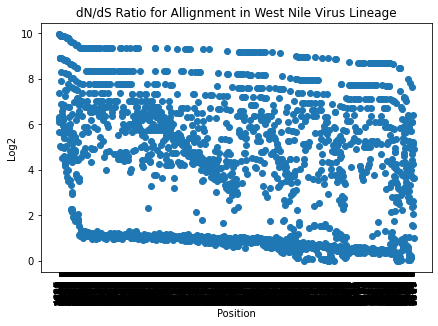

In [22]:
#Histogram parameters 
fig, ax = plt.subplots()
ax.scatter(dN_dS_f.iloc[:,0], dN_dS_f.iloc[:,4])
plt.tight_layout()
plt.title("dN/dS Ratio for Allignment in West Nile Virus Lineage")
plt.xlabel("Position")
plt.xticks(rotation=90)
plt.ylabel("Log2")
plt.show()

In [23]:
fig.savefig('FinalPlot.png')